ugh
24
        name   lat    lon      diam           age      age_low      age_upp  \
0    Haworth -87.5  354.8   51400.0  4.180000e+09   20000000.0   20000000.0   
1  Shoemaker -88.1   45.9   51800.0  4.150000e+09   20000000.0   20000000.0   
2   Faustini -87.2   84.3   42500.0  4.100000e+09   30000000.0   30000000.0   
3   Amundsen -84.4   83.1  103400.0  3.900000e+09  100000000.0  100000000.0   
4     Cabeus -85.3  317.9  100600.0  3.880000e+09  100000000.0  100000000.0   

       rad      psr_area              x              y      dist2pole  
0  25700.0  1.867491e+09   -6866.947452   75455.049594   75790.922768  
1  25900.0  1.896671e+09   41357.284767   40077.997131   57601.101304  
2  21250.0  1.276763e+09   84432.505109    8427.484385   84885.833500  
3  51700.0  7.557418e+09  168273.855497   20363.374013  169771.667000  
4  50300.0  7.153661e+09  -95419.936436  105603.336116  142486.934804  


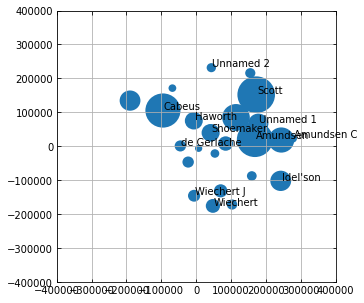

In [5]:
import numpy as np
import pandas as pd
import rasterio as rio
import mixing as model
import matplotlib.pyplot as plt

plt.rcParams.update({
    'figure.figsize': (8, 8),
    'figure.facecolor': 'white',
    'xtick.top': True,
    'xtick.direction': 'in',
    'ytick.right': True,
    'ytick.direction': 'in',
})

# Constants
f24 = False
pct_area = 1.30e4
hop_efficiency = 0.054  # From modified Kloos model with Hayne area - Cannon 2020
timesteps = np.arange(425)[::-1] * 0.01  # Gyr, each step is 10 Myr

# Read in Cannon 2020 crater list
fcraters = '~/projects/essi21/data/cannon2020_crater_ages.csv'
cols = ('name', 'lat', 'lon', 'diam', 'age', 'age_low', 'age_upp')
df = model.read_crater_list(fcraters, cols)
# df = pd.read_csv(fcraters, names=cols, header=0)
# df['x'], df['y'] = model.latlon2xy2(df.lat, df.lon)
# df['rad'] = df.diam / 2
print(len(df))
print(df.head())

# Show crater locations
fig, ax = plt.subplots(figsize=(5, 5))
for i, row in df.sort_values('lat').reset_index().iterrows():
    crater = plt.Circle((row.x, row.y), row.diam/2)
    ax.add_patch(crater)
    if i % 2:
        ax.annotate(row['name'], (row.x, row.y), xytext=(1, 1), textcoords='offset points')
ax.set_xlim(-400e3, 400e3)
ax.set_ylim(-400e3, 400e3)
plt.grid()
plt.show()

In [33]:
def latlon2xy(lat, lon):
    X = gc_dist(0, -90, lon, lat)
    return 

df['x2'], df['y2'] = latlon2xy(df.lat, df.lon)


ValueError: too many values to unpack (expected 2)

In [32]:
df.head(20)

,name,lat,lon,diam,age,age_low,age_upp,x,y,rad,x2,y2
0,Haworth,-87.5,354.8,51.4,4.18,0.02,0.02,-6.866947,75.455050,25.70,-6.866947,75.455050
1,Shoemaker,-88.1,45.9,51.8,4.15,0.02,0.02,41.357285,40.077997,25.90,41.357285,40.077997
2,Faustini,-87.2,84.3,42.5,4.10,0.03,0.03,84.432505,8.427484,21.25,84.432505,8.427484
3,Amundsen,-84.4,83.1,103.4,3.90,0.10,0.10,168.273855,20.363374,51.70,168.273855,20.363374
4,Cabeus,-85.3,317.9,100.6,3.88,0.10,0.10,-95.419936,105.603336,50.30,-95.419936,105.603336
5,Cabeus B,-82.3,305.4,59.6,3.90,0.10,0.10,-189.707956,134.818427,29.80,-189.707956,134.818427
6,de Gerlache,-88.5,271.7,32.7,3.90,0.10,0.10,-45.449346,1.348905,16.35,-45.449346,1.348905
7,Hedervari,-81.9,85.6,74.1,3.90,0.10,0.10,244.024114,18.776632,37.05,244.024114,18.776632
8,Idel'son L,-84.0,118.6,28.0,3.90,0.10,0.10,159.411805,-86.914137,14.00,159.411805,-86.914137
9,Unnamed 1,-83.7,69.2,57.7,3.90,0.10,0.10,178.185718,67.686405,28.85,178.185718,67.686405


In [29]:
if 'rad' in df.columns:
    print('a')

a


In [17]:
R_MOON = 1737
def gc_dist(lon1, lat1, lon2, lat2, rp=R_MOON):
    """
    Calculate the great circle distance between two points using the Haversine formula.

    All args must be of equal length, lon and lat in decimal degrees.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return rp * 2 * np.arcsin(np.sqrt(a))

def dist(x1, y1, x2, y2):
    """Return simple distance between coordinates (x1, y1) and (x2, y2)."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

In [38]:
grdstep = 0.5
grd_x, grd_y = np.ogrid[-grdsize:grdsize:grdstep, -grdsize:grdsize:grdstep]
len(grd_x)

1600

In [7]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def dist(x1, y1, x2, y2):
    """Return simple distance between coordinates (x1, y1) and (x2, y2)."""
    return np.sqrt((x2 - x1)**2 + (y2 - y1)**2)

def get_ejecta_distances(df, grd_x, grd_y):
    """
    Return 3D array shape (len(grd_x), len(grd_y), len(df)) of ejecta distances 
    from each crater in df.

    Distances computed with gc_dist. Distances within crater radius are NaN.
    """
    ej_dist_all = np.zeros([len(grd_x), len(grd_y), len(df)])
    for i, crater in df.iterrows():
        X = grd_x - crater.x
        Y = grd_y - crater.y
        ej_dist = dist(crater.x, crater.y, X, Y)
        ej_dist[ej_dist < crater.rad] = np.nan
        print(ej_dist_all.shape)
        ej_dist_all[:, :, i] = ej_dist
    return ej_dist_all

get_ejecta_distances(df, mixing.GRD_X, mixing.GRD_Y)

(800, 1, 24)


ValueError: could not broadcast input array from shape (800,800) into shape (800,1)

In [12]:
(mixing.GRD_Y.flatten()).shape

(800,)

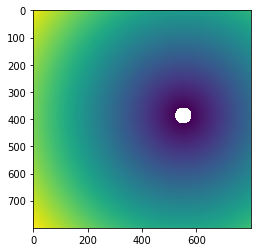

In [2]:
import mixing

ej_dist = mixing.main(plot=True)

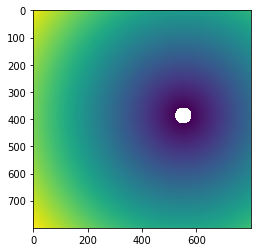

In [3]:
import mixing
import matplotlib.pyplot as plt
df = mixing.read_crater_list()
ej_dist_all = mixing.get_ejecta_distances(df)
plt.imshow(ej_dist_all[:, :, 0])

In [40]:
len(df)

24

In [34]:
ej_dist_all = np.zeros([grdsize*2, grdsize*2, len(df)])
grd_x, grd_y = np.ogrid[-grdsize:grdsize:grdstep, -grdsize:grdsize:grdstep]
for i, crater in df.iterrows():
    X = grd_x - crater.x
    Y = grd_y - crater.y
    ej_dist = dist(crater.x, crater.y, X, Y)
    ej_dist[ej_dist < crater.rad] = np.nan
    ej_dist_all[:, :, i] = ej_dist
    

NameError: name 'grdstep' is not defined

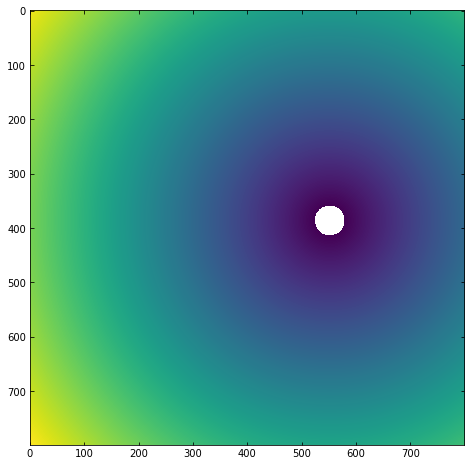

In [28]:
plt.imshow(ej_dist_all[:, :, 0])

In [9]:
Y

array([[  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       ...,
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399],
       [  0,   1,   2, ..., 397, 398, 399]])

In [2]:
# All craters from Robbins 2018
frobbins = '/home/cjtu/projects/essi21/data/lunar_crater_database_robbins_2018.csv'
stu_df = pd.read_csv(frobbins, header=0)

# Reformat cols and compute x, y coords
sdf = stu_df[['CRATER_ID', 'LAT_CIRC_IMG', 'LON_CIRC_IMG', 'DIAM_CIRC_IMG']]
sdf = sdf.rename({
    'CRATER_ID': 'ID', 
    'LAT_CIRC_IMG': 'lat', 
    'LON_CIRC_IMG': 'lon', 
    'DIAM_CIRC_IMG': 'diam'}, axis='columns')
sdf['rad'] = sdf.diam / 2
sdf['x'], sdf['y'] = model.latlon2xy(sdf.lat, sdf.lon)
sdf.head()

,ID,lat,lon,diam,rad,x,y
0,00-1-000000,-19.83040,264.7570,940.960,470.480,-1627.160995,-149.314620
1,00-1-000001,44.77630,328.6020,249.840,124.920,-642.384051,1052.476626
2,00-1-000002,57.08660,82.0995,599.778,299.889,934.876447,129.733142
3,00-1-000003,1.96124,230.6220,558.762,279.381,-1341.874937,-1101.365888
4,00-1-000004,-49.14960,266.3470,654.332,327.166,-1133.839393,-72.388170


130 craters (Diam > 20.90 km) within 250 km of S. pole
 37 craters with ejecta that reaches grid
 13 craters with ejecta that reaches < 6 deg from S pole


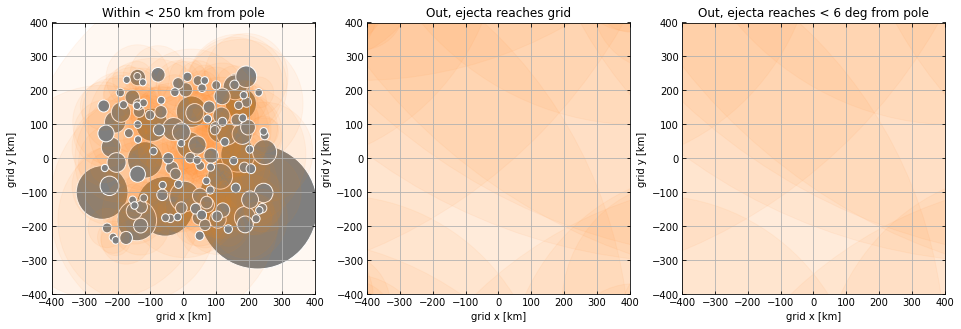

In [3]:
# Stu robbins craters > mindiam, touching model grid
# Only does simple distance (ToDo: great circle dist)
mindiam = 20.9
grdsize = 400
neargrd = sdf[(sdf.diam >= mindiam) &
              (sdf.x.abs() < grdsize + 4*sdf.rad) & 
              (sdf.y.abs() < grdsize + 4*sdf.rad)]
neargrd = neargrd.sort_values('rad', ascending=False).reset_index(drop=True)

# Stu robbins craters inside the model grid
inside = neargrd[(neargrd.x.abs() < 250) & (neargrd.y.abs() < 250)]
print(f'{len(inside):3} craters (Diam > {mindiam:.2f} km) within 250 km of S. pole')

# Stu robbins craters with 4-crater-radius ejecta that reach the model grid
outside = neargrd[(neargrd.x.abs() > 400) & (neargrd.y.abs() > 400)]
print(f'{len(outside):3} craters with ejecta that reaches grid')

# Stu robbins craters with 4-crater-radius ejecta that reach the model grid
six_deg_from_spole = 181.94  # [km]
outside_reaches_pole = outside[(outside.x.abs() < six_deg_from_spole + 4*outside.rad) & 
                               (outside.y.abs() < six_deg_from_spole + 4*outside.rad)]
print(f'{len(outside_reaches_pole):3} craters with ejecta that reaches < 6 deg from S pole')

# Show crater locations
titles = ('Within < 250 km from pole', 'Out, ejecta reaches grid', 'Out, ejecta reaches < 6 deg from pole')
gdfs = [inside, outside, outside_reaches_pole]
fig, axs = plt.subplots(1, 3, figsize=(16, 5))
for title, gdf, ax in zip(titles, gdfs, axs):
    ax.set_title(title)
    ax.grid()
    ax.set_xlim(-grdsize, grdsize)
    ax.set_ylim(-grdsize, grdsize)
    ax.set_xlabel('grid x [km]')
    ax.set_ylabel('grid y [km]')
    for i, row in gdf.iterrows():
        ejecta = plt.Circle((row.x, row.y), row.rad*4, color='tab:orange', alpha=0.05)
        ax.add_patch(ejecta)
        crater = plt.Circle((row.x, row.y), row.rad, facecolor='tab:gray', edgecolor='white')
        ax.add_patch(crater)


plt.show()

In [117]:
names = ['Imbrium', 'Crisium', 'Tranquilitatis', 'Nectaris', 'Serenitatis', 'Humorum', 'Coulomb-Sarton', 'Fecunditatis', 'Moscoviense', 'Mutus-Vlacq', 'Unnamed?', 'Birkhoff', 'Planck']
outside_reaches_pole['name'] = names
outside_reaches_pole[['name', 'diam', 'lat', 'lon']].reset_index(drop=True)
outside_reaches_pole.to_csv('/home/cjtu/projects/essi21/data/distant_craters_ejecta_reach_lt_6_deg_spole.csv')


<ipython-input-117-36b288516d47>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  outside_reaches_pole['name'] = names


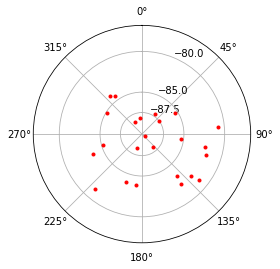

In [223]:
ax = plt.subplot(111, polar=True)
ax.plot(df.lon-90, df.lat, color='r', ls='none', marker='.')
ax.set_rmax(deg_from_pole-90)
ax.set_rticks([-87.5, -85, -80])
ax.set_theta_zero_location('N')
ax.set_theta_direction(-1)

In [24]:
spole_stereo_wkt = """PROJCS["Moon_South_Pole_Stereographic",
                        GEOGCS["Moon 2000",
                            DATUM["D_Moon_2000",
                                SPHEROID["Moon_2000_IAU_IAG",1737400.0,0.0]],
                            PRIMEM["Greenwich",0],
                            UNIT["Decimal_Degree",0.0174532925199433]],
                        PROJECTION["Stereographic"],
                        PARAMETER["False_Easting",0],
                        PARAMETER["False_Northing",0],
                        PARAMETER["Central_Meridian",0],
                        PARAMETER["Scale_Factor",1],
                        PARAMETER["Latitude_Of_Origin",-90],
                        UNIT["Meter",1]]"""

In [21]:
grid_xsize = grid_ysize = 800  # [pix]
xres = yres = 1000  # [m/pix]

transform = rio.Affine(xres, 0, -grid_xsize*xres, 0, -yres, grid_ysize*yres)
crs = rio.crs.CRS.from_wkt(spole_stereo_wkt)

xarr = np.arange(grid_xsize)
yarr = np.arange(grid_ysize)
grd_x, grd_y = np.meshgrid(xarr, yarr, indexing='ij')


In [31]:
from rasterio import Affine as A
from rasterio.warp import reproject, Resampling
crs_spole_m = rio.crs.CRS.from_wkt(spole_stereo_wkt)
crs_spole_stereo_deg = rio.crs.CRS.from_wkt(spole_stereo_deg_wkt)
with rio.Env():

    # As source: a 512 x 512 raster centered on 0 degrees E and 0
    # degrees N, each pixel covering 15".
    rows, cols = src_shape = (512, 512)
    d = 1.0/240 # decimal degrees per pixel
    # The following is equivalent to
    # A(d, 0, -cols*d/2, 0, -d, rows*d/2).
    src_transform = A.translation(-cols*d/2, rows*d/2) * A.scale(d, -d)
    src_crs = crs_spole_m
    source = np.ones(src_shape, np.uint8)*255

    # Destination: a 1024 x 1024 dataset in Web Mercator (EPSG:3857)
    # with origin at 0.0, 0.0.
    dst_shape = (1024, 1024)
    dst_transform = A.translation(-237481.5, 237536.4) * A.scale(425.0, -425.0)
    dst_crs = crs_spole_deg
    destination = np.zeros(dst_shape, np.uint8)

    reproject(
        source,
        destination,
        src_transform=src_transform,
        src_crs=src_crs,
        dst_transform=dst_transform,
        dst_crs=dst_crs,
        resampling=Resampling.nearest)


In [3]:
# make ejecta matrix
R_MOON = 1737  # km
def get_transient_crater_rad(rad, rsc=9.5):
    """Return apparant transient crater radius given radius of final crater (eqn. 9, Xie 2020)."""
    if rad < rsc:
        # Simple crater
        return 0.7 * rad
    # Complex crater
    return 0.7 * rsc**0.15 * rad**0.85

def ejecta_thickness(dist, rad_at):
    """Return ejecta thickness at dist [m] from crater with apparant transient crater radius rad_at (eqn. 3, Xie 2020)"""
    return 0.068 * rad_at * (dist / rad_at) ** -3

def gc_dist(lon1, lat1, lon2, lat2, rp=R_MOON):
    """
    Calculate the great circle distance between two points using the Haversine formula.

    All args must be of equal length, lon and lat in decimal degrees.
    """
    lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
    dlon = lon2 - lon1
    dlat = lat2 - lat1
    a = np.sin(dlat/2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon/2.0)**2
    return rp * 2 * np.arcsin(np.sqrt(a))

df['rad'] = df['diam'] / 2
df['rad_at'] = df['rad'].apply(get_transient_crater_rad)
df.tail()

,name,lat,lon,diam,age,age_low,age_upp,rad,rad_at
19,Unnamed 3,-83.9,338.3,22.3,3.40,0.50,0.10,11.15,7.619741
20,Wiechert U,-83.4,149.0,30.0,3.40,0.70,0.10,15.00,9.804696
21,Wiechert J,-85.2,182.4,34.9,3.20,0.10,0.30,17.45,11.150201
22,Shackleton,-89.7,129.8,20.9,3.15,0.08,0.05,10.45,7.211165
23,Amundsen C,-80.8,85.2,24.2,1.80,0.20,0.20,12.10,8.168158


In [71]:
f = '/home/cjtu/projects/essi21/data/spole.tif'
arr = np.arange(grid_xsize*grid_ysize).reshape((grid_xsize, grid_ysize))
arr = np.sin(np.rad2deg(grd_x))

rows = cols = 800  # [pix]
res = 0.0174532925199433  # [deg/pix]  75 deg to pole
transform = rio.Affine(xres, 0, -cols*res/2, 0, -yres, rows*res/2)
crs = rio.crs.CRS.from_wkt(spole_stereo_deg_wkt)
profile = {
    'driver': 'GTiff',
    'height': arr.shape[0],
    'width': arr.shape[1],
    'count': 1,
    'dtype': arr.dtype,
    'crs': crs_spole_stereo_deg,
    'transform': transform
}
with rio.open(f, 'w', **profile) as dst:
    dst.write(arr, 1)


<bound method TransformMethodsMixin.index of <open DatasetReader name='/home/cjtu/projects/essi21/data/spole.tif' mode='r'>>
0 0
0 0


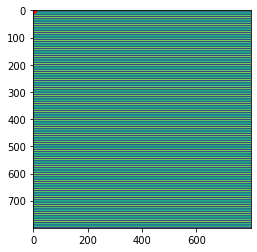

In [87]:
lat = -89.9999
lon = 50
with rio.open(f) as src:
    rows, cols = rio.transform.rowcol(src.transform, lon, lat)
    y, x = src.index(lon, lat)
    print(src.index)

print(rows, cols)
print(x, y)
fig, ax = plt.subplots()
ax.imshow(arr)
ax.scatter(x, y, color='r')

In [90]:
# Make grid centered on S pole
minlat = -80
size = 401  # odd
def polar_grid_360(deg_from_pole, size=401, pole='s'):
    """Returns grid centered on pole to lat 90 - deg_from_pole."""
    sign = 1 if pole == 'n' else -1
    minlat = sign * (90 - deg_from_pole)
    lon_arr = np.linspace(0, 360, size)
    # Center lat on pole
    lat_arr = np.linspace(minlat, sign*90, size//2 + 1)
    lat_arr = np.append(lat_arr, lat_arr[:-1][::-1])
    lon_grid, lat_grid = np.meshgrid(lon_arr, lat_arr)
    return lon_grid, lat_grid

xarr = yarr = np.arange(400)
grd_x, grd_y = np.meshgrid(xarr, yarr, indexing='ij')


In [190]:
def pol2cart(r, theta):
    """Return polar coords in cartesian (x, y)."""
    x = r * np.cos(theta)
    y = r * np.sin(theta)
    return (x, y)

def cart2pol(x, y):
    """Return cartesian coords in polar (r, theta)."""
    r = np.sqrt(x**2 + y**2)
    theta = np.arctan2(y, x)
    return (r, theta)

def latlon2xy(lat, lon, rp=R_MOON):
    """Return (x, y) from pole in units of rp from (lat, lon) [degrees]."""
    theta, azimuth = np.deg2rad(lat), np.deg2rad(lon)
    y = r * np.cos(lat) * np.cos(lon)
    x = r * np.cos(lat) * np.sin(lon)
    return x, y

deg_from_pole = 90 - 76.80885
r = np.linspace(0, deg_from_pole, 400)
theta = np.linspace(0, 2*np.pi, 400)
r_grd, theta_grd = np.meshgrid(r, theta)
x, y = pol2cart(r_grd, theta_grd)

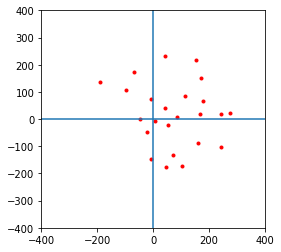

In [193]:
R_MOON = 1737
df2 = df
def latlon2xy(lat, lon, r=R_MOON):
    """Return """
    y, x, _ = sph2cart(df2.lat.values, df2.lon.values, R_MOON)
    return (x, y)

def nearest2D(x, y, xarr, yarr):
    """Find index of closest value in arr to val"""
    xgrd, ygrd = np.meshgrid(xarr, yarr, indexing='ij')
    return np.sqrt((xgrd - x)**2 + (ygrd - y)**2).argmin()



yind, xinds, _ = sph2cart(df2.lat.values, df2.lon.values, R_MOON)
plt.figure(figsize=(4, 4))
plt.plot(y, x, 'r.')
plt.xlim(-400, 400)
plt.ylim(-400, 400)
plt.axhline(0)
plt.axvline(0)
plt.show()